# Demo 5 - K-Means Clustering in Hadoop and Spark
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Spring 2019`__

Designing MapReduce algorithms involves two kinds of planning. First we have to figure out which parts of a calculation can be performed in parallel and which can't. Then we have to figure out how to put those pieces together so that the right information ends up in the right place at the right time. That's what the Hadoop shuffle is all about. Today we'll talk about a few techniques to optimize your Hadoop jobs as well as some of the limitations of this framework.
By the end of this demo you should be able to:  
* ... __implement__ K-Means using Hadoop and Spark RDDs.
* ... __explain__ how the centroid initialization affects K-Means results & time to convergence.
* ... __list__ a few limitations of the Hadoop Framework.

__NOTE__: _At the end of this notebook we've provided a Spark implementation that fixes some of our frustrations with Hadoop. This is intended to set the stage for next week when we'll start a more formal introduction to Spark_.

### Notebook Set-Up

In [1]:
# imports
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%reload_ext autoreload
%autoreload 2

In [2]:
# globals
JAR_FILE = "/usr/lib/hadoop-mapreduce/hadoop-streaming.jar"
HOME_DIR = "/media/notebooks" # this is where docker mounts your repo, ADJUST AS NEEDED
DEMO_DIR = HOME_DIR + "/LiveSessionMaterials/wk04Demo_Kmeans"
HDFS_DIR = "/user/root/demo4"
!hdfs dfs -mkdir {HDFS_DIR}

In [3]:
# <--- SOLUTION --->
# ... for instructors ...
HOME_DIR = "/media/notebooks/Instructors/"
DEMO_DIR = HOME_DIR + "/LiveSessionMaterials/wk04Demo_Kmeans/master"

In [4]:
# store notebook environment path
from os import environ
PATH  = environ['PATH']

__`REMINDER:`__ If you are running this notebook from the course Docker container you can track your Hadoop Jobs using the UI at: http://localhost:19888/jobhistory/

# Content Review: Kmeans

K-Means clustering is an algorithm designed to group examples into K distinct groups based on their features. K-Means clustering can be used to categorize data when we do not have any concrete information about what those categories may look like. For example we may want to perform a market segmentation analysis on our customers but we don't actually know what the segments are.

At a high level clustering is an attempt to group objects in such a way as to make those objects similar to other objects within the group and dissimilar to those outside of the group. In order to perform K-Means clustering we want to minimize the distance between all of the examples that are a part of a cluster and the center of that cluster, also called the _cluster centroid_. The clustering algorithm solves the following cost minimization:

$$
\arg\min_{c} \sum_{i=1}^k\sum_{{x}\in c_i} \left\Vert {x}-\mu_i \right\Vert^2
$$

It turns out that the above minimization problem is very difficult to solve (t falls into the class of problems known as [NP-Hard](https://en.wikipedia.org/wiki/NP-hardness)). The K-Means algorithm attempts to solve this clustering problem iteratively by repeating the 2-step process of marking each example as belonging to a single cluster by finding the closest cluster centroid
and then adjusting each of the K cluster centroids so that each centroid is in the middle of all the examples that belong to that centroid.

[Here](http://stanford.edu/class/ee103/visualizations/kmeans/kmeans.html) is a simple visualization of the process. There are a number of up front choices that must be made before the algorithm can be implemented:

* __K__: the total number of centroids is selected using some apriori information about the desired outcome
* __Distance Function__: typically the euclidian distance is used but this can be any function $d({x}, \mu)$
* __Convergence Criteria__: a rule used to determine when the iterative process can stop.

The formal algorithm can then be defined as follows. First, decide the number of clusters $K$. Then:


| Step | Description | Pseudocode|        
| :---: |:---------------------------------------------: |:--------------- |
|1 |Initialize the center ('centroid') of the clusters| ${\mu}_i = $ random value $, i=1,...,k$|
|2|Attribute the closest cluster to each data point|${c}_i = \{j: d({x}_j, \mu_i) \le d({x}_j, \mu_l),  l \ne i, j=1,...,n\}$|
|3| Update centroid to the mean of points in that cluster|$\mu_i = \frac{1}{|c_i|}\sum_{j\in c_i} {x}_j,\forall i$|
|4|Repeat steps 2-3 until convergence criteria met||
||Notation:|${|c|} = $ number of elements in  ${c}$|

## Load Demo Data for K-means

The Iris dataset was used in R.A. Fisher's classic 1936 paper, [The Use of Multiple Measurements in Taxonomic Problems](http://rcs.chemometrics.ru/Tutorials/classification/Fisher.pdf). It includes three iris species with 50 samples each as well as some properties about each flower. One flower species is linearly separable from the other two, but the other two are not linearly separable from each other.

The columns in this dataset are:
> `Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species`

If you want to learn more about this dataset visit the [UCI Iris Data Set page](https://archive.ics.uci.edu/ml/datasets/iris). Use the cells below to download, preprocess and visualize this data set.

In [5]:
# make data directory
!mkdir data

mkdir: cannot create directory `data': File exists


In [6]:
# download the iris dataset
!curl -L -O https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4551  100  4551    0     0  23703      0 --:--:-- --:--:-- --:--:-- 23703


In [7]:
# a few data cleaning steps... (remove blank last line, & separate features from labels)
!head -n -1 iris.data > data/iris_full.csv
!cut -d ',' -f 1-4 data/iris_full.csv > data/iris_features.csv
!rm iris.data

In [8]:
# take a look at the first few lines
!head data/iris_full.csv

5.1,3.5,1.4,0.2,Iris-setosa
4.9,3.0,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
4.6,3.1,1.5,0.2,Iris-setosa
5.0,3.6,1.4,0.2,Iris-setosa
5.4,3.9,1.7,0.4,Iris-setosa
4.6,3.4,1.4,0.3,Iris-setosa
5.0,3.4,1.5,0.2,Iris-setosa
4.4,2.9,1.4,0.2,Iris-setosa
4.9,3.1,1.5,0.1,Iris-setosa


In [9]:
# copy the iris data to hdfs for use with hadoop streaming in subsequent exercises
!hdfs dfs -copyFromLocal data/iris_features.csv {HDFS_DIR}

In [10]:
# set up constants for ease of directory use
IRIS_DATA_WITH_LABELS = DEMO_DIR + '/data/iris_full.csv'
IRIS_DATA = DEMO_DIR + '/data/iris_features.csv'
IRIS_DATA_HDFS = HDFS_DIR + '/iris_features.csv'
OUTPUT_HDFS = HDFS_DIR + "/new_centroids"

## Visualize Demo Data for Kmeans

For purposes of visualization of this dataset we use a PCA decomposition to project the 4 dimensional iris dataset down to 2 dimensions. This will give us the ability to roughly visualize the effectiveness of our K-Means clustering.

In [11]:
# read in labeled data
mapping = {b'Iris-setosa': 0, 
           b'Iris-versicolor': 1, 
           b'Iris-virginica': 2}
names = mapping.keys()
data = np.loadtxt(IRIS_DATA_WITH_LABELS, delimiter=',', 
                  converters = {4: lambda s: mapping[s]})

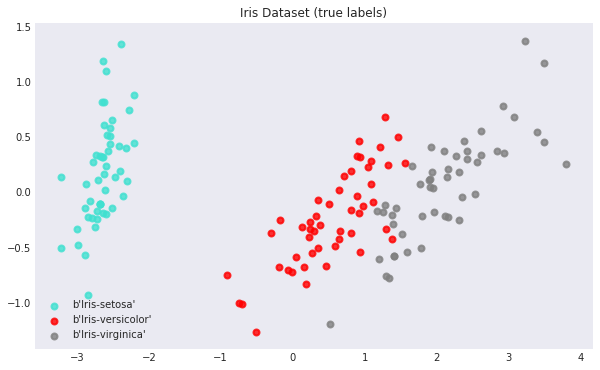

In [12]:
# custom plotting function
from utils import plot_iris_data
plot_iris_data(data[:,0:-1], data[:,-1], names, 'Iris Dataset (true labels)')

# K-Means in Python

## Implementation
A simple (non-scalable) implementation in Python. For this example we will use the Iris dataset without labels and a K of 3 since we know apriori there are 3 different species labels (setosa, versicolor, and virginica).

In [13]:
import numpy as np

# read in the data from the IRIS_DATA file
samples = np.loadtxt(IRIS_DATA, 
                     delimiter=',')

# define the number of clusters
k = 3

# define the distance function as the normalized distance
def distance(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)

def closestCluster(sample, centers):
    distances = distance(sample, centers)
    return np.argmin(distances)

# define the convergence criteria
convergenceCriteria = .001

# (step1) set the k initial clusters by assigning a random point
centroids = samples[np.random.choice(len(samples), 
                                     size=k, 
                                     replace=False)]

while True:
    # (step2) attribute the closest cluster to each point
    clusters = [closestCluster(sample, centroids) 
                for sample 
                in samples]
    
    # (step3) set the position of each cluster to the mean of all data points belonging to that cluster
    last_centroids = np.copy(centroids)
    for i in range(k):
        points = [samples[j] 
                  for j 
                  in range(len(samples)) if clusters[j] == i]
        centroids[i] = np.mean(points, axis=0)
    
    # (step4) repeat steps 2-3 until convergence criteria met
    error = distance(centroids, 
                     last_centroids, 
                     None)
    if error < convergenceCriteria:
        break

print('-------Final Centroids-------')
print(centroids)

-------Final Centroids-------
[[5.006      3.418      1.464      0.244     ]
 [6.85384615 3.07692308 5.71538462 2.05384615]
 [5.88360656 2.74098361 4.38852459 1.43442623]]


## Results
Examine the results by assigning each of the datapoints in the file to the nearest cluster and then plot all of the samples along with their labels.

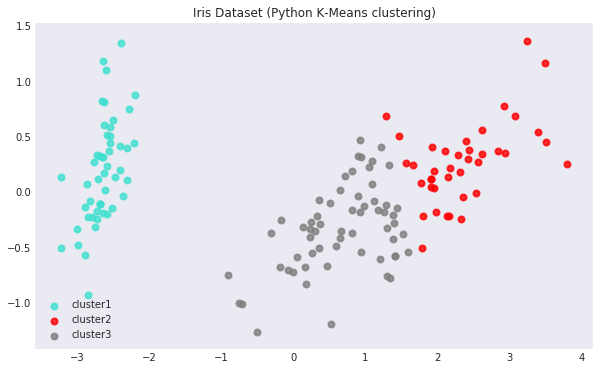

In [14]:
labels = list(map(lambda sample: closestCluster(sample, centroids), samples))
plot_iris_data(np.array(samples), np.array(labels), ['cluster1', 'cluster2', 'cluster3'],
                'Iris Dataset (Python K-Means clustering)')

# K-Means in Hadoop MapReduce

Topics to cover
* Decomposition of algorithm into map and reduce phases
* Sorting and how shuffle works with this

## Mapper
The primary job of the mapper is to classify points based on the given clusters. The clusters are randomly initialized (as in the previous Python example) but due to the distributed nature of Hadoop those centroid locations cannot be stored in memory. Instead we write them to a file and read them at the beginning of the map phase. The mapper then determines the nearest centroid and subsequently emits the sample point along with the centroid that point belongs to. In addition we emit a 'count' value which will serve a purpose when we look at integrating a combiner. The output format is then

$(index, count, point)$

Where the index is the key to be aggregated by the reducer

In [15]:
%%writefile mapper.py
#!/usr/bin/env python
import sys, math

CLUSTERS_FILENAME = 'centroids.txt'

centroid_points = [list(map(float, s.split('\n')[0].split(','))) 
                   for s 
                   in open(CLUSTERS_FILENAME, 'r').readlines()]

for line in sys.stdin:
    data = [float(x) 
            for x 
            in line.strip().split(',')]

    minDistance, index = 0, -1
    for i in range(len(centroid_points)):
        centroid = centroid_points[i]
        distance = sum([(centroid[ix]-data[ix])**2 
                    for ix 
                    in range(len(data))])**2
        if minDistance:
            if distance < minDistance:                    
                minDistance, index = distance, i
        else:
            minDistance, index = distance, i
    print(f"{index}\t{1}\t{line.strip()}")

Overwriting mapper.py


In [16]:
!chmod a+x mapper.py

## Reducer
Each reducer will collect all the samples belonging to one or more clusters and subsequently calculate and then emit the new cluster centroids.

In [17]:
%%writefile reducer.py
#!/usr/bin/env python
import sys, re, math
from operator import add

oldKey = None
sumOfCoords = None
countOfCoords = 0

emit = lambda i, s, c: '\t'.join([str(i), ','.join([str(x/c) for x in s])])

for line in sys.stdin:
    line = line.strip().split('\t')
    index, count, coords  = int(line[0]), int(line[1]), [float(x) 
                                                         for x 
                                                         in line[2].split(',')]
    if oldKey is not None and oldKey != index:
        print(emit(oldKey, sumOfCoords, countOfCoords))
        sumOfCoords = None
        countOfCoords = 0
    
    oldKey = index
    sumOfCoords = map(add, sumOfCoords, coords) if sumOfCoords else coords
    countOfCoords += int(count)

if oldKey != None:
    print(emit(oldKey, sumOfCoords, countOfCoords))

Overwriting reducer.py


In [18]:
!chmod a+x reducer.py

## Initializer
Each of the $K$ centroids are initialized to a random point from the dataset.

In [19]:
import numpy as np

k = 3

samples = np.loadtxt(IRIS_DATA, 
                     delimiter=',')
centroids = samples[np.random.choice(len(samples), 
                                     size=k, 
                                     replace=False)]
np.savetxt('centroids.txt', centroids, fmt='%.2f', delimiter=',')

In [20]:
!cat centroids.txt

6.10,3.00,4.60,1.40
5.10,3.80,1.50,0.30
5.90,3.20,4.80,1.80


## Unit Test

In [21]:
!cat iris-cut.data | ./mapper.py | sort -k 1,1 | ./reducer.py

cat: iris-cut.data: No such file or directory


## Run

In [22]:
# Hadoop streaming command
!hdfs dfs -rm -r {OUTPUT_HDFS}
!hadoop jar {JAR_FILE} \
  -files mapper.py,reducer.py,centroids.txt \
  -mapper mapper.py \
  -reducer reducer.py \
  -input {IRIS_DATA_HDFS} \
  -output {OUTPUT_HDFS} \
  -cmdenv PATH={PATH}

rm: `/user/root/demo4/new_centroids': No such file or directory
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.15.0.jar] /tmp/streamjob5744697104603608363.jar tmpDir=null
18/09/26 06:25:45 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
18/09/26 06:25:45 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
18/09/26 06:25:46 INFO mapred.FileInputFormat: Total input paths to process : 1
18/09/26 06:25:46 INFO mapreduce.JobSubmitter: number of splits:2
18/09/26 06:25:47 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1537941729753_0001
18/09/26 06:25:48 INFO impl.YarnClientImpl: Submitted application application_1537941729753_0001
18/09/26 06:25:48 INFO mapreduce.Job: The url to track the job: http://quickstart.cloudera:8088/proxy/application_1537941729753_0001/
18/09/26 06:25:48 INFO mapreduce.Job: Running job: job_1537941729753_0001
18/09/26 06:26:03 INFO mapreduce.Job: Job job_1537941729753_0001 running in uber mo

In [23]:
!hdfs dfs -cat {OUTPUT_HDFS}/part-0000*

0	5.985999999999998,2.73,4.3180000000000005,1.3239999999999998
1	5.004081632653062,3.4102040816326533,1.4632653061224496,0.2428571428571428
2	6.509803921568627,3.029411764705882,5.415686274509803,1.994117647058823


## Adding a Combiner
This particular K-Means implementation can benefit greatly from the addition of a combiner. 

In [24]:
%%writefile combiner.py
#!/usr/bin/env python
import sys, re, math
from operator import add

oldKey = None
sumOfCoords = None
countOfCoords = 0

emit = lambda i, s, c: '\t'.join([str(i), str(c), ','.join([str(x) for x in s])])

for line in sys.stdin:
    line = line.strip().split('\t')
    index, count, coords  = int(line[0]), int(line[1]), [float(x) 
                                                         for x 
                                                         in line[2].split(',')]
    if oldKey is not None and oldKey != index:
        print(emit(oldKey, sumOfCoords, countOfCoords))
        sumOfCoords = None
        countOfCoords = 0
    
    oldKey = index
    sumOfCoords = map(add, sumOfCoords, coords) if sumOfCoords else coords
    countOfCoords += int(count)

if oldKey != None:
    print(emit(oldKey, sumOfCoords, countOfCoords))

Writing combiner.py


In [25]:
!chmod a+x combiner.py

## Run with Combiner

In [26]:
# Hadoop streaming command
!hdfs dfs -rm -r {OUTPUT_HDFS}
!hadoop jar {JAR_FILE} \
  -files mapper.py,combiner.py,reducer.py,centroids.txt \
  -mapper mapper.py \
  -combiner combiner.py \
  -reducer reducer.py \
  -input {IRIS_DATA_HDFS} \
  -output {OUTPUT_HDFS} \
  -cmdenv PATH={PATH}

Deleted /user/root/demo4/new_centroids
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.15.0.jar] /tmp/streamjob3312296411882424101.jar tmpDir=null
18/09/26 06:26:48 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
18/09/26 06:26:49 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
18/09/26 06:26:50 INFO mapred.FileInputFormat: Total input paths to process : 1
18/09/26 06:26:50 INFO mapreduce.JobSubmitter: number of splits:2
18/09/26 06:26:50 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1537941729753_0002
18/09/26 06:26:51 INFO impl.YarnClientImpl: Submitted application application_1537941729753_0002
18/09/26 06:26:51 INFO mapreduce.Job: The url to track the job: http://quickstart.cloudera:8088/proxy/application_1537941729753_0002/
18/09/26 06:26:51 INFO mapreduce.Job: Running job: job_1537941729753_0002
18/09/26 06:26:59 INFO mapreduce.Job: Job job_1537941729753_0002 running in uber mode : false
18/09/26 06:26

In [27]:
!hdfs dfs -cat {OUTPUT_HDFS}/part-0000*

0	5.986000000000001,2.73,4.3180000000000005,1.324
1	5.004081632653062,3.4102040816326533,1.4632653061224496,0.2428571428571428
2	6.509803921568628,3.029411764705882,5.415686274509803,1.994117647058823


## Discussion

This is only a single iteration. How do we accomplish multiple iterations with Hadoop streaming?

# K-Means in Spark

This is boilerplate code required for a notebook in this enviroment to create a local spark context.

In [28]:
from pyspark.sql import SparkSession

app_name = "example_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

## Implementation
Compare this Spark K-Means implementation to the original, non-scalable implementation in Python. Structurally they are quite similar.

In [29]:
import numpy as np

lines = sc.textFile(IRIS_DATA)
samples = lines.map(lambda line: np.array([float(x) for x in line.split(',')])).cache()

# define the number of clusters
k = 3

# define the distance function as the normalized distance
def distance(a, b):
    return np.linalg.norm(a - b)

def closestCluster(p, centers):
    bestIndex = 0
    closest = float("+inf")
    for i in range(len(centers)):
        tempDist = distance(p, centers[i])
        if tempDist < closest:
            closest = tempDist
            bestIndex = i
    return bestIndex

# define the convergence criteria
convergenceCriteria = .001

# (step1) set the k initial clusters by assigning a random point
centroids = samples.takeSample(False, k, 1)

while True:
    # (step2) attribute the closest cluster to each point
    clusters = samples.map(
        lambda p: (closestCluster(p, centroids), (p, 1)))
    
    newpoints = clusters.reduceByKey(
        lambda p1_c1, p2_c2: (p1_c1[0] + p2_c2[0], p1_c1[1] + p2_c2[1])).map(
        lambda st: (st[0], st[1][0] / st[1][1])).collect()
    
    error = sum(np.sum(distance(centroids[iK], p)) for (iK, p) in newpoints)
        
    # (step3) set the position of each cluster to the mean of all data points belonging to that cluster
    for (iK, p) in newpoints:
        centroids[iK] = p
        
    # (step4) repeat steps 2-3 until convergence criteria met
    if error < convergenceCriteria:
        break
    
print('-------Final Centroids-------')
print(np.array(centroids))

-------Final Centroids-------
[[5.9016129  2.7483871  4.39354839 1.43387097]
 [6.85       3.07368421 5.74210526 2.07105263]
 [5.006      3.418      1.464      0.244     ]]


## Results
Examine the results by assigning each of the datapoints in the file to the nearest cluster and then plot all of the samples along with their labels.

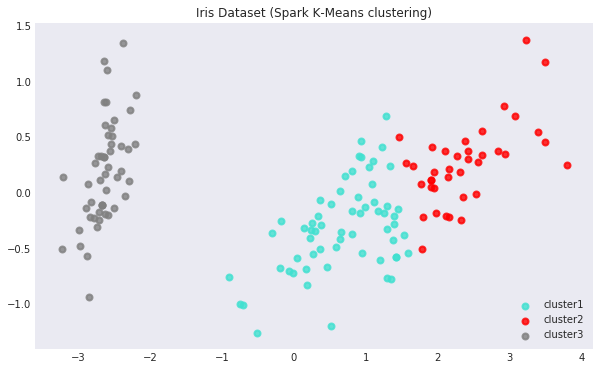

In [31]:
samples = np.loadtxt(IRIS_DATA, 
                     delimiter=',')
labels = list(map(lambda sample: closestCluster(sample, centroids), 
             samples))
plot_iris_data(np.array(samples), 
     np.array(labels), 
     ['cluster1', 'cluster2', 'cluster3'],
     'Iris Dataset (Spark K-Means clustering)')